In [22]:
import pandas as pd 
import numpy as np

In [23]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

In [24]:
oecd_data = pd.read_csv("./data/2015.csv",index_col='TIME_PERIOD',)

In [26]:
imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(oecd_data)
dataframe=pd.DataFrame(df_filled, columns = oecd_data.columns)

In [35]:
dataframe.head()

,Balance_of_payments,Business_tendency_and_consumer_opinion_surveys,Composite_leading_indicators,Financial_statistics_share_price_index,Financial_statistics_Long-term interest rates,Industry,International_trade,Labour_market_statistics,Consumer_price_indices,GDP
0,-9950.728,11.00000,99.21700,104.11170,2.540000,99.20680,-0.170918,71.83637,0.187617,1627610.5
1,-16122.420,9.00000,99.39775,104.19950,2.756667,98.60985,-4.743276,72.02551,0.655431,1630612.4
2,-14626.290,12.33333,100.44730,97.31507,2.773333,101.04420,-2.741926,72.12034,0.465116,1647952.1
3,-16007.980,9.00000,101.02720,94.37376,2.773333,101.01620,-4.706390,72.50604,0.370370,1657387.1
4,-12338.980,17.00000,101.88640,91.08822,2.593333,102.69150,-5.114379,72.53805,-0.184502,1671354.3


In [28]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import *

In [29]:
#Separate Features and target
X_Target = dataframe['GDP'] # the 
feature_df= dataframe.loc[:, dataframe.columns != 'GDP']
#Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_df, X_Target, test_size=0.3, random_state=0)
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(X_train, y_train)
ypred = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, ypred)
print("R2:{0:.4f}, MSE:{1:.4f}, RMSE:{2:.4f}"
      .format(score, mse, np.sqrt(mse)))

R2:0.9919, MSE:32515102.9835, RMSE:5702.2016
C:\Python\anaconda\envs\algotrading\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8073697.819737084, tolerance: 4499724.757348002
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python\anaconda\envs\algotrading\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9278893.680070588, tolerance: 5112375.481192309
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python\anaconda\envs\algotrading\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10565678.365719281, tolerance: 5938685.55579343
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python\anacon

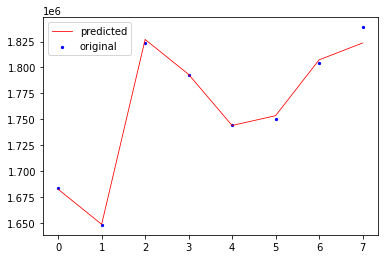

In [34]:
import matplotlib.pyplot as plt
x_ax = range(len(X_test))
#plt.scatter(x_ax, y_test, s=5, color='blue', label='original')
plt.scatter(x_ax, y_test, s=5, color='blue', label='original')
plt.plot(x_ax, ypred, lw=0.8, color='red', label='predicted')
plt.legend()
plt.show()

In [40]:
import joblib
import pickle

In [44]:
filename = './data/finalized_model.sav'

In [45]:
joblib.dump(model, filename)

['./data/finalized_model.sav']

In [49]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9918969167852345


In [51]:
new_pred =loaded_model.predict(X_test)

In [52]:
new_pred

array([1682396.59052473, 1648510.84512296, 1827013.96900451,
       1793281.63927103, 1743941.44091844, 1753408.00967401,
       1807298.091153  , 1823571.02187209])

In [ ]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column